In [26]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


### Load data

In [27]:
data_dir = Path.cwd().parent / "data"

df = pd.read_csv(data_dir / "crsp_compustat_raw.csv", parse_dates=["MthCalDt"])
df["YYYYMM"] = df["MthCalDt"].dt.to_period("M").astype(str)

crsp = pd.read_csv(data_dir / "crsp_raw.csv", parse_dates=["date"])
crsp["YYYYMM"] = crsp["date"].dt.to_period("M").astype(str)

df = df.merge(
    crsp[["PERMNO", "YYYYMM", "SHRCD", "EXCHCD"]], on=["PERMNO", "YYYYMM"], how="left"
)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327144 entries, 0 to 327143
Data columns (total 48 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   gvkey            327144 non-null  int64         
 1   datadate         327144 non-null  object        
 2   fyear            327144 non-null  int64         
 3   indfmt           327144 non-null  object        
 4   consol           327144 non-null  object        
 5   popsrc           327144 non-null  object        
 6   datafmt          327144 non-null  object        
 7   tic              327141 non-null  object        
 8   cusip            327144 non-null  object        
 9   conm             327144 non-null  object        
 10  curcd            327144 non-null  object        
 11  fyr              327144 non-null  int64         
 12  at               304833 non-null  float64       
 13  ceq              301653 non-null  float64       
 14  cogs             303

In [29]:
df.head()

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,cusip,conm,...,MthCap,MthRet,MthRetx,SecurityType,SecuritySubType,ShareType,PrimaryExch,ShrOut,SHRCD,EXCHCD
0,1000,1970-12-31,1970,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,...,21903.75,-0.043478,-0.043478,EQTY,COM,NS,A,2655.0,10.0,2.0
1,1000,1971-12-31,1971,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,...,15930.00,-0.094340,-0.094340,EQTY,COM,NS,A,2655.0,10.0,2.0
2,1000,1972-12-31,1972,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,...,7965.00,-0.040000,-0.040000,EQTY,COM,NS,A,2655.0,10.0,2.0
3,1000,1973-12-31,1973,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,...,6969.38,0.050000,0.050000,EQTY,COM,NS,A,2655.0,10.0,2.0
4,1000,1974-12-31,1974,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,...,6201.06,0.146341,0.146341,EQTY,COM,NS,A,2111.0,10.0,2.0


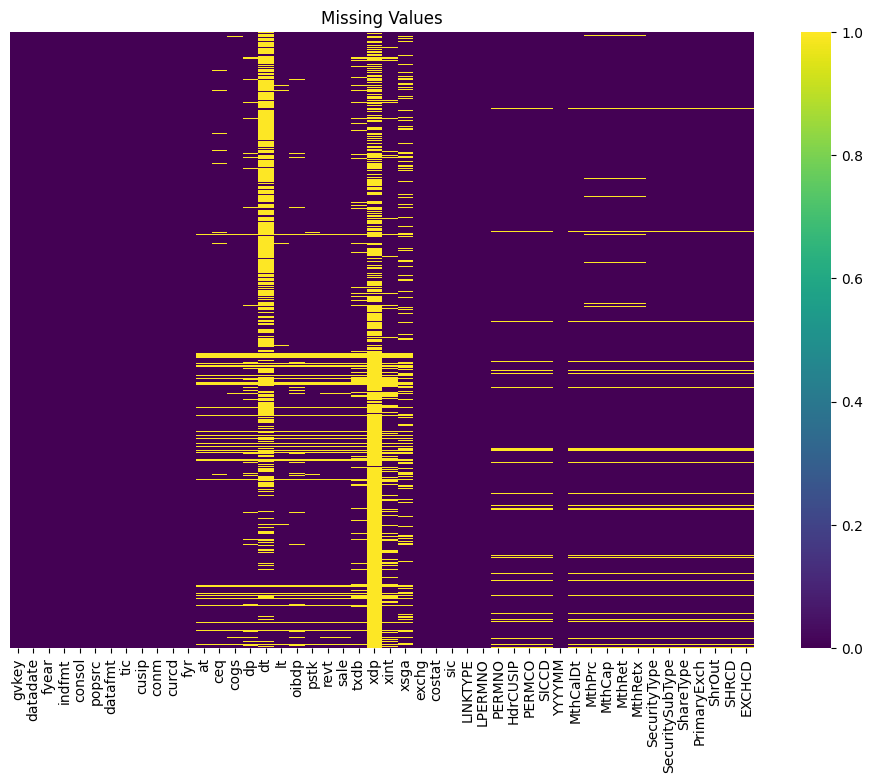

In [30]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=True, cmap="viridis", yticklabels=False)
plt.title("Missing Values")
plt.show()

### Stock universe filtering

In [43]:
# Filters:
df = df[df["SHRCD"].isin([10, 11])]  # common stock only
df = df[df["EXCHCD"].isin([1, 2, 3])]  # NYSE/AMEX/NASDAQ
df = df[(df["SICCD"] < 6000) | (df["SICCD"] > 6799)]  # no finance/insurance/REIT

# Now use a heuristic for finding big companies to only include, used to avoid survivorship-bias
# Must already have MthCap or MthPrc * ShrOut
df["ME"] = df["MthCap"]  # or df["MthPrc"] * df["ShrOut"]

# Extract June each year
df_june = df[df["MthCalDt"].dt.month == 6].copy()

# NYSE only firms
june_nyse = df_june[df_june["EXCHCD"] == 1]

# Compute NYSE median each June
size_breakpoints = (
    june_nyse.groupby(june_nyse["MthCalDt"].dt.year)["ME"]
    .median()
    .rename("NYSE_Median")
)

df_june = df_june.merge(
    size_breakpoints, left_on=df_june["MthCalDt"].dt.year, right_index=True
)

# Assign BIG / SMALL
df_june["SIZE"] = np.where(df_june["ME"] >= df_june["NYSE_Median"], "BIG", "SMALL")

# The paper keeps ONLY big stocks
df_big = df_june[df_june["SIZE"] == "BIG"].copy()

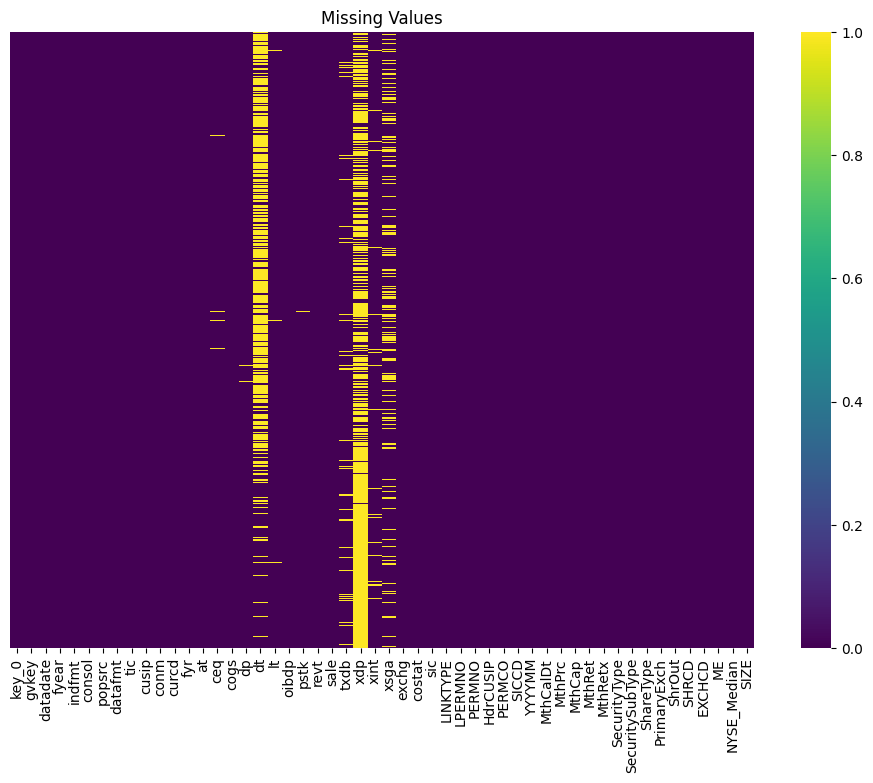

In [39]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_big.isnull(), cbar=True, cmap="viridis", yticklabels=False)
plt.title("Missing Values")
plt.show()

In [44]:
# Define target columns
cols_to_keep = [
    # identifiers
    "PERMNO",
    "gvkey",
    "tic",
    "cusip",
    "conm",
    "YYYYMM",
    "MthCalDt",
    # market data
    "MthPrc",
    "MthRet",
    "MthRetx",
    "ShrOut",
    "ME",
    # core balance sheet variables
    "at",
    "ceq",
    "pstk",
    "lt",
    # profitability
    "oibdp",
    "revt",
    "sale",
    # expenses
    "cogs",
    "dp",
    "xint",
    "xsga",
    # tax
    "txdb",
    "dt",
    # industry
    "sic",
    "SICCD",
]

df_big = df_big[cols_to_keep].copy()

# Rename for clarity
df_big = df_big.rename(
    columns={
        "at": "total_assets",
        "ceq": "book_equity",
        "pstk": "preferred_stock",
        "lt": "total_liabilities",
        "oibdp": "oper_income",
        "revt": "revenue",
        "sale": "sales",
        "cogs": "cogs_expense",
        "dp": "depr_amort",
        "xint": "interest_expense",
        "xsga": "sga_expense",
        "txdb": "tax_deferred",
        "dt": "total_taxes",
    }
)


In [45]:
df_big.head()


,PERMNO,gvkey,tic,cusip,conm,YYYYMM,MthCalDt,MthPrc,MthRet,MthRetx,...,revenue,sales,cogs_expense,depr_amort,interest_expense,sga_expense,tax_deferred,total_taxes,sic,SICCD
115,10006.0,1010,4165A,00099V004,ACF INDUSTRIES INC,1970-06,1970-06-30,38.500,0.000000,0.000000,...,320.200,320.200,222.510,18.980,9.260,27.120,36.149,NaN,3743,3743.0
116,10006.0,1010,4165A,00099V004,ACF INDUSTRIES INC,1971-06,1971-06-30,55.250,-0.006742,-0.006742,...,333.718,333.718,238.889,20.992,11.354,28.650,44.941,NaN,3743,3743.0
117,10006.0,1010,4165A,00099V004,ACF INDUSTRIES INC,1972-06,1972-06-30,43.375,-0.025281,-0.025281,...,332.704,332.704,238.345,22.865,13.084,30.190,54.574,NaN,3743,3743.0
118,10006.0,1010,4165A,00099V004,ACF INDUSTRIES INC,1973-06,1973-06-29,45.500,0.034091,0.034091,...,343.679,343.679,242.330,23.231,13.247,32.612,66.551,NaN,3743,3743.0
119,10006.0,1010,4165A,00099V004,ACF INDUSTRIES INC,1974-06,1974-06-28,44.000,0.047619,0.047619,...,436.146,436.146,321.079,24.864,14.976,35.575,76.981,NaN,3743,3743.0
